In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, backend
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from PyEMD import CEEMDAN
from dataset import kline_data, prepare_prediction_data, get_daily_volume_profile
from models import rnn_gru
from utils import plot_volume_profile

In [2]:
btc_1m = kline_data(interval='1m')
btc_1d = kline_data(interval='1d')

Last saved data candle close time: 2021-08-19 09:06:00
Last saved data candle close time: 2021-08-19 00:00:00


In [3]:
n_data = 1000
train_ratio = 0.85
data = btc_1d.iloc[btc_1d.index.values[-n_data:]]

In [4]:
n_bins = 20
profiles = []
for idx, row in data.iterrows():
    date = row['open_time'].split()[0]
    profile = get_daily_volume_profile(btc_1m, date, n_bins=n_bins)
    profiles.append(profile)

In [5]:
pocs = []
for profile in profiles:
    poc = profile['price'].iloc[profile['total_volume'].argmax()]
    pocs.append(poc)

In [6]:
d_poc_p = []
for i in range(1, len(pocs)):
    d_poc_p.append((pocs[i] - pocs[i - 1]) / pocs[i - 1])
d_poc_p = np.array(d_poc_p)

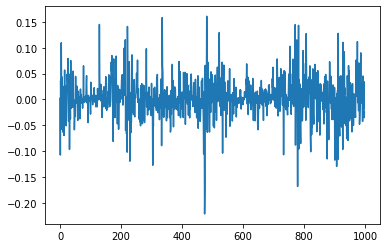

In [7]:
plt.plot(d_poc_p)

## d_poc_p + EMD

In [8]:
ceemdan = CEEMDAN()
imfs = ceemdan.ceemdan(d_poc_p).T
imfs.shape

(999, 8)

In [9]:
input_size = 20
train_pred = []
test_pred = []
for i in range(imfs.shape[1]):
    print(f'*** IMF {i + 1} / {imfs.shape[1]} ***')
    minmax = MinMaxScaler()
    data_norm = np.squeeze(minmax.fit_transform(np.expand_dims(imfs[:, i], axis=-1)))
    x, y = prepare_prediction_data(data_norm, input_size=input_size)
    n_samples = x.shape[0]
    x_train = np.expand_dims(x[:int(n_samples * train_ratio), :], axis=-1)
    x_test = np.expand_dims(x[int(n_samples * train_ratio):, :], axis=-1)
    y_train = y[:int(n_samples * train_ratio)]
    y_test = y[int(n_samples * train_ratio):]
    
    model = rnn_gru(input_size=input_size)
    ea = EarlyStopping(patience=20)
    cp = ModelCheckpoint('saved_models/gru_d_poc_p_1d.h5')
    cb = [ea, cp]
    history = model.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=cb, validation_split=0.3)
    
    print(f'Test set MSE: {model.evaluate(x_test, y_test, verbose=0)}')
    y_test_pred = np.squeeze(minmax.inverse_transform(model.predict(x_test)))
    test_pred.append(y_test_pred)
    
    y_train_pred = np.squeeze(minmax.inverse_transform(model.predict(x_train)))
    train_pred.append(y_train_pred)

*** IMF 1 / 8 ***
Epoch 1/100
19/19 [==============================] - 4s 56ms/step - loss: 0.0172 - val_loss: 0.0199
Epoch 2/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0166 - val_loss: 0.0197
Epoch 3/100
19/19 [==============================] - 0s 22ms/step - loss: 0.0166 - val_loss: 0.0196
Epoch 4/100
19/19 [==============================] - 1s 29ms/step - loss: 0.0165 - val_loss: 0.0198
Epoch 5/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0165 - val_loss: 0.0193
Epoch 6/100
19/19 [==============================] - 0s 25ms/step - loss: 0.0163 - val_loss: 0.0191
Epoch 7/100
19/19 [==============================] - 0s 26ms/step - loss: 0.0163 - val_loss: 0.0191
Epoch 8/100
19/19 [==============================] - 0s 25ms/step - loss: 0.0160 - val_loss: 0.0192
Epoch 9/100
19/19 [==============================] - 0s 25ms/step - loss: 0.0160 - val_loss: 0.0184
Epoch 10/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0157 

19/19 [==============================] - 1s 33ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 18/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 19/100
19/19 [==============================] - 0s 24ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 20/100
19/19 [==============================] - 0s 22ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 21/100
19/19 [==============================] - 0s 24ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 22/100
19/19 [==============================] - 0s 19ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 23/100
19/19 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 24/100
19/19 [==============================] - 0s 26ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 25/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 26/100
19/19 [==============================] - 0s 22ms/step - loss: 0.0017 - val_loss: 0.0021
Epo

19/19 [==============================] - 0s 24ms/step - loss: 5.8978e-04 - val_loss: 2.4952e-04
Epoch 32/100
19/19 [==============================] - 0s 23ms/step - loss: 6.0124e-04 - val_loss: 9.6737e-04
Epoch 33/100
19/19 [==============================] - 0s 21ms/step - loss: 6.5138e-04 - val_loss: 4.8713e-04
Epoch 34/100
19/19 [==============================] - 0s 20ms/step - loss: 6.2110e-04 - val_loss: 2.3763e-04
Epoch 35/100
19/19 [==============================] - 0s 19ms/step - loss: 6.5651e-04 - val_loss: 5.0265e-04
Epoch 36/100
19/19 [==============================] - 0s 24ms/step - loss: 6.3350e-04 - val_loss: 2.6613e-04
Epoch 37/100
19/19 [==============================] - 0s 23ms/step - loss: 5.1203e-04 - val_loss: 4.7332e-04
Epoch 38/100
19/19 [==============================] - 0s 20ms/step - loss: 5.2814e-04 - val_loss: 2.5046e-04
Epoch 39/100
19/19 [==============================] - 0s 18ms/step - loss: 5.2091e-04 - val_loss: 2.2454e-04
Epoch 40/100
19/19 [============

19/19 [==============================] - 1s 28ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 7/100
19/19 [==============================] - 0s 24ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 8/100
19/19 [==============================] - 0s 25ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 9/100
19/19 [==============================] - 0s 22ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 10/100
19/19 [==============================] - 0s 22ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 11/100
19/19 [==============================] - 0s 19ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 12/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 13/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 14/100
19/19 [==============================] - 0s 22ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 15/100
19/19 [==============================] - 0s 23ms/step - loss: 8.9544e-04 - val_loss: 0.0010
Ep

19/19 [==============================] - 1s 27ms/step - loss: 2.8874e-04 - val_loss: 2.3056e-04
Epoch 83/100
19/19 [==============================] - 1s 27ms/step - loss: 2.3488e-04 - val_loss: 2.3275e-04
Epoch 84/100
19/19 [==============================] - 0s 27ms/step - loss: 2.3846e-04 - val_loss: 2.3265e-04
Epoch 85/100
19/19 [==============================] - 1s 29ms/step - loss: 2.1849e-04 - val_loss: 1.9426e-04
Epoch 86/100
19/19 [==============================] - 1s 28ms/step - loss: 2.7028e-04 - val_loss: 2.9808e-04
Epoch 87/100
19/19 [==============================] - 0s 25ms/step - loss: 2.6850e-04 - val_loss: 2.0690e-04
Epoch 88/100
19/19 [==============================] - 0s 26ms/step - loss: 2.4609e-04 - val_loss: 2.1568e-04
Epoch 89/100
19/19 [==============================] - 0s 26ms/step - loss: 2.3487e-04 - val_loss: 3.9010e-04
Epoch 90/100
19/19 [==============================] - 0s 25ms/step - loss: 2.2239e-04 - val_loss: 2.7420e-04
Epoch 91/100
19/19 [============

19/19 [==============================] - 0s 24ms/step - loss: 1.7879e-04 - val_loss: 4.5443e-05
Epoch 58/100
19/19 [==============================] - 0s 24ms/step - loss: 1.8226e-04 - val_loss: 7.5389e-05
Epoch 59/100
19/19 [==============================] - 1s 28ms/step - loss: 1.9323e-04 - val_loss: 1.9011e-05
Epoch 60/100
19/19 [==============================] - 0s 23ms/step - loss: 1.5517e-04 - val_loss: 2.0646e-05
Epoch 61/100
19/19 [==============================] - 0s 22ms/step - loss: 1.6294e-04 - val_loss: 7.8784e-05
Epoch 62/100
19/19 [==============================] - 0s 22ms/step - loss: 1.5994e-04 - val_loss: 1.5173e-05
Epoch 63/100
19/19 [==============================] - 0s 24ms/step - loss: 1.5910e-04 - val_loss: 3.3384e-05
Epoch 64/100
19/19 [==============================] - 0s 23ms/step - loss: 1.5548e-04 - val_loss: 6.0769e-05
Epoch 65/100
19/19 [==============================] - 0s 23ms/step - loss: 1.6430e-04 - val_loss: 5.4962e-06
Epoch 66/100
19/19 [============

19/19 [==============================] - 0s 23ms/step - loss: 5.8674e-05 - val_loss: 1.5955e-04
Epoch 48/100
19/19 [==============================] - 0s 23ms/step - loss: 3.9847e-05 - val_loss: 2.0377e-04
Epoch 49/100
19/19 [==============================] - 0s 23ms/step - loss: 3.0744e-05 - val_loss: 2.2504e-04
Epoch 50/100
19/19 [==============================] - 0s 22ms/step - loss: 3.4064e-05 - val_loss: 1.4884e-04
Epoch 51/100
19/19 [==============================] - 1s 27ms/step - loss: 3.7672e-05 - val_loss: 9.7233e-05
Epoch 52/100
19/19 [==============================] - 0s 23ms/step - loss: 6.7799e-05 - val_loss: 2.1188e-04
Epoch 53/100
19/19 [==============================] - 0s 20ms/step - loss: 3.4854e-05 - val_loss: 1.6099e-04
Epoch 54/100
19/19 [==============================] - 0s 21ms/step - loss: 3.0322e-05 - val_loss: 1.6357e-04
Epoch 55/100
19/19 [==============================] - 0s 22ms/step - loss: 2.8160e-05 - val_loss: 2.0085e-04
Epoch 56/100
19/19 [============

19/19 [==============================] - 0s 22ms/step - loss: 1.3804e-04 - val_loss: 4.8971e-04
Epoch 53/100
19/19 [==============================] - 0s 23ms/step - loss: 1.5901e-04 - val_loss: 8.2889e-05
Epoch 54/100
19/19 [==============================] - 0s 23ms/step - loss: 1.2808e-04 - val_loss: 7.3261e-05
Epoch 55/100
19/19 [==============================] - 0s 22ms/step - loss: 1.3117e-04 - val_loss: 1.2680e-04
Epoch 56/100
19/19 [==============================] - 0s 23ms/step - loss: 1.1639e-04 - val_loss: 9.0955e-05
Epoch 57/100
19/19 [==============================] - 0s 23ms/step - loss: 1.1260e-04 - val_loss: 1.8418e-04
Epoch 58/100
19/19 [==============================] - 0s 23ms/step - loss: 1.4258e-04 - val_loss: 2.6737e-04
Epoch 59/100
19/19 [==============================] - 0s 22ms/step - loss: 1.2402e-04 - val_loss: 2.2771e-04
Epoch 60/100
19/19 [==============================] - 0s 23ms/step - loss: 1.1776e-04 - val_loss: 9.5586e-05
Epoch 61/100
19/19 [============

19/19 [==============================] - 0s 24ms/step - loss: 2.8328e-05 - val_loss: 0.0067
Epoch 38/100
19/19 [==============================] - 0s 22ms/step - loss: 3.9854e-05 - val_loss: 0.0066
Epoch 39/100
19/19 [==============================] - 0s 22ms/step - loss: 2.8873e-05 - val_loss: 0.0064
Epoch 40/100
19/19 [==============================] - 0s 22ms/step - loss: 2.4986e-05 - val_loss: 0.0066
Epoch 41/100
19/19 [==============================] - 0s 24ms/step - loss: 1.6817e-05 - val_loss: 0.0066
Epoch 42/100
19/19 [==============================] - 0s 22ms/step - loss: 1.5802e-05 - val_loss: 0.0062
Epoch 43/100
19/19 [==============================] - 0s 23ms/step - loss: 1.5138e-05 - val_loss: 0.0062
Epoch 44/100
19/19 [==============================] - 0s 23ms/step - loss: 1.4640e-05 - val_loss: 0.0062
Epoch 45/100
19/19 [==============================] - 0s 22ms/step - loss: 1.5173e-05 - val_loss: 0.0061
Epoch 46/100
19/19 [==============================] - 0s 25ms/step -

In [10]:
y_test_pred = np.sum(np.array(test_pred).T, axis=1)
y_test_pred.shape

(147,)

In [11]:
y_train_pred = np.sum(np.array(train_pred).T, axis=1)
y_train_pred.shape

(832,)

In [12]:
test_open_prices = np.array(pocs)[-y_test_pred.shape[0] - 1:-1]
test_close_prices = np.array(pocs)[-y_test_pred.shape[0]:]
train_open_prices = np.array(pocs)[input_size:-y_test_pred.shape[0] - 1]
train_close_prices = np.array(pocs)[input_size + 1:-y_test_pred.shape[0]]

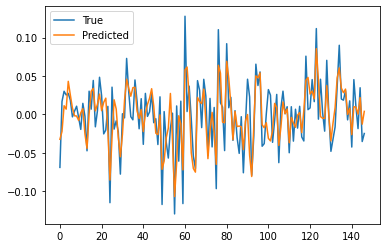

In [13]:
x, y = prepare_prediction_data(d_poc_p, input_size=input_size)
n_samples = x.shape[0]
y_test = y[int(n_samples * train_ratio):]

plt.plot(y_test, label='True')
plt.plot(y_test_pred, label='Predicted')
plt.legend()

In [14]:
d_poc_p_test = y_test_pred
d_poc_test = d_poc_p_test * test_open_prices
test_close_prices_pred = test_open_prices + d_poc_test

d_poc_p_train = y_train_pred
d_poc_train = d_poc_p_train * train_open_prices
train_close_prices_pred = train_open_prices + d_poc_train

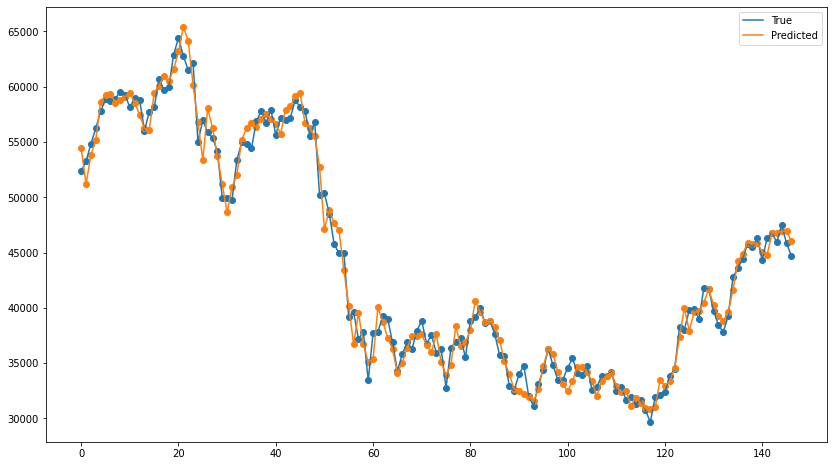

In [15]:
plt.figure(figsize=(14, 8))
plt.plot(test_close_prices, label='True')
plt.plot(test_close_prices_pred, label='Predicted')
plt.scatter(np.arange(test_close_prices.shape[0]), test_close_prices)
plt.scatter(np.arange(test_close_prices.shape[0]), test_close_prices_pred)
plt.legend()

In [16]:
print(f'Test set MAE: {mean_absolute_error(test_close_prices, test_close_prices_pred)}')
print(f'Test set MAPE: {mean_absolute_percentage_error(test_close_prices, test_close_prices_pred)}')

Test set MAE: 1018.546369776534
Test set MAPE: 0.023432503353915012


In [17]:
error_train = train_close_prices - train_close_prices_pred
error_test = test_close_prices - test_close_prices_pred
print(error_train.shape, error_test.shape)

(832,) (147,)


In [18]:
n_test_samples = error_test.shape[0]
all_error = np.concatenate((error_train, error_test))
all_error.shape

(979,)

In [19]:
ceemdan = CEEMDAN()
error_imfs = ceemdan.ceemdan(all_error).T
error_imfs.shape

(979, 9)

In [20]:
input_size = 20
test_pred = []
for i in range(error_imfs.shape[1]):
    print(f'*** IMF {i + 1} / {error_imfs.shape[1]} ***')
    minmax = MinMaxScaler()
    data_norm = np.squeeze(minmax.fit_transform(np.expand_dims(error_imfs[:, i], axis=-1)))
    x, y = prepare_prediction_data(data_norm, input_size=input_size)
    n_samples = x.shape[0]
    x_train = np.expand_dims(x[:-n_test_samples, :], axis=-1)
    x_test = np.expand_dims(x[-n_test_samples:, :], axis=-1)
    y_train = y[:-n_test_samples]
    y_test = y[-n_test_samples:]
    
    model = rnn_gru(input_size=input_size)
    ea = EarlyStopping(patience=20)
    cp = ModelCheckpoint('saved_models/gru_d_oc_p_1d.h5')
    cb = [ea, cp]
    history = model.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=cb, validation_split=0.3)
    
    print(f'Test set MSE: {model.evaluate(x_test, y_test, verbose=0)}')
    y_test_pred = np.squeeze(minmax.inverse_transform(model.predict(x_test)))
    test_pred.append(y_test_pred)

*** IMF 1 / 9 ***
Epoch 1/100
18/18 [==============================] - 3s 49ms/step - loss: 0.0011 - val_loss: 0.0230
Epoch 2/100
18/18 [==============================] - 0s 18ms/step - loss: 9.9565e-04 - val_loss: 0.0230
Epoch 3/100
18/18 [==============================] - 0s 23ms/step - loss: 9.7299e-04 - val_loss: 0.0231
Epoch 4/100
18/18 [==============================] - 0s 24ms/step - loss: 9.6224e-04 - val_loss: 0.0230
Epoch 5/100
18/18 [==============================] - 0s 23ms/step - loss: 9.7429e-04 - val_loss: 0.0230
Epoch 6/100
18/18 [==============================] - 0s 23ms/step - loss: 9.8494e-04 - val_loss: 0.0229
Epoch 7/100
18/18 [==============================] - 0s 24ms/step - loss: 9.5595e-04 - val_loss: 0.0228
Epoch 8/100
18/18 [==============================] - 0s 25ms/step - loss: 9.5872e-04 - val_loss: 0.0228
Epoch 9/100
18/18 [==============================] - 0s 26ms/step - loss: 9.5912e-04 - val_loss: 0.0226
Epoch 10/100
18/18 [==============================

Epoch 79/100
18/18 [==============================] - 0s 26ms/step - loss: 8.7077e-04 - val_loss: 0.0184
Epoch 80/100
18/18 [==============================] - 0s 27ms/step - loss: 8.4874e-04 - val_loss: 0.0185
Epoch 81/100
18/18 [==============================] - 0s 25ms/step - loss: 8.7703e-04 - val_loss: 0.0183
Epoch 82/100
18/18 [==============================] - 0s 28ms/step - loss: 8.7412e-04 - val_loss: 0.0184
Epoch 83/100
18/18 [==============================] - 1s 29ms/step - loss: 8.5813e-04 - val_loss: 0.0184
Epoch 84/100
18/18 [==============================] - 0s 27ms/step - loss: 8.4671e-04 - val_loss: 0.0184
Epoch 85/100
18/18 [==============================] - 0s 25ms/step - loss: 8.4984e-04 - val_loss: 0.0182
Epoch 86/100
18/18 [==============================] - 0s 23ms/step - loss: 8.5810e-04 - val_loss: 0.0183
Epoch 87/100
18/18 [==============================] - 0s 25ms/step - loss: 8.5672e-04 - val_loss: 0.0183
Epoch 88/100
18/18 [==============================] - 0

18/18 [==============================] - 0s 25ms/step - loss: 6.2233e-05 - val_loss: 0.0017
Epoch 57/100
18/18 [==============================] - 0s 24ms/step - loss: 6.3268e-05 - val_loss: 0.0016
Epoch 58/100
18/18 [==============================] - 0s 26ms/step - loss: 6.3625e-05 - val_loss: 0.0016
Epoch 59/100
18/18 [==============================] - 1s 39ms/step - loss: 6.3646e-05 - val_loss: 0.0016
Epoch 60/100
18/18 [==============================] - 1s 31ms/step - loss: 6.5426e-05 - val_loss: 0.0016
Epoch 61/100
18/18 [==============================] - 0s 27ms/step - loss: 6.2849e-05 - val_loss: 0.0016
Epoch 62/100
18/18 [==============================] - 0s 25ms/step - loss: 6.1360e-05 - val_loss: 0.0016
Epoch 63/100
18/18 [==============================] - 0s 27ms/step - loss: 6.0727e-05 - val_loss: 0.0016
Epoch 64/100
18/18 [==============================] - 0s 26ms/step - loss: 6.2668e-05 - val_loss: 0.0015
Epoch 65/100
18/18 [==============================] - 0s 25ms/step -

18/18 [==============================] - 0s 25ms/step - loss: 8.7168e-05 - val_loss: 0.0020
Epoch 34/100
18/18 [==============================] - 0s 25ms/step - loss: 8.3515e-05 - val_loss: 0.0018
Epoch 35/100
18/18 [==============================] - 0s 27ms/step - loss: 7.7322e-05 - val_loss: 0.0018
Epoch 36/100
18/18 [==============================] - 1s 34ms/step - loss: 9.9679e-05 - val_loss: 0.0018
Epoch 37/100
18/18 [==============================] - 1s 34ms/step - loss: 8.9264e-05 - val_loss: 0.0017
Epoch 38/100
18/18 [==============================] - 1s 29ms/step - loss: 7.4790e-05 - val_loss: 0.0017
Epoch 39/100
18/18 [==============================] - 1s 34ms/step - loss: 1.1960e-04 - val_loss: 0.0019
Epoch 40/100
18/18 [==============================] - 1s 29ms/step - loss: 1.0221e-04 - val_loss: 0.0017
Epoch 41/100
18/18 [==============================] - 0s 25ms/step - loss: 8.3617e-05 - val_loss: 0.0017
Epoch 42/100
18/18 [==============================] - 0s 23ms/step -

18/18 [==============================] - 0s 27ms/step - loss: 5.1278e-04 - val_loss: 0.0062
Epoch 11/100
18/18 [==============================] - 0s 25ms/step - loss: 2.9886e-04 - val_loss: 0.0037
Epoch 12/100
18/18 [==============================] - 1s 38ms/step - loss: 2.1037e-04 - val_loss: 0.0034
Epoch 13/100
18/18 [==============================] - 1s 29ms/step - loss: 2.0142e-04 - val_loss: 0.0032
Epoch 14/100
18/18 [==============================] - 0s 27ms/step - loss: 1.9119e-04 - val_loss: 0.0031
Epoch 15/100
18/18 [==============================] - 0s 27ms/step - loss: 1.3849e-04 - val_loss: 0.0028
Epoch 16/100
18/18 [==============================] - 0s 25ms/step - loss: 1.3526e-04 - val_loss: 0.0026
Epoch 17/100
18/18 [==============================] - 0s 26ms/step - loss: 1.2033e-04 - val_loss: 0.0024
Epoch 18/100
18/18 [==============================] - 0s 26ms/step - loss: 1.0668e-04 - val_loss: 0.0023
Epoch 19/100
18/18 [==============================] - 0s 25ms/step -

18/18 [==============================] - 0s 26ms/step - loss: 1.3351e-05 - val_loss: 0.0012
Epoch 89/100
18/18 [==============================] - 0s 24ms/step - loss: 1.2698e-05 - val_loss: 0.0012
Epoch 90/100
18/18 [==============================] - 0s 24ms/step - loss: 1.4403e-05 - val_loss: 0.0012
Epoch 91/100
18/18 [==============================] - 0s 23ms/step - loss: 1.2458e-05 - val_loss: 0.0012
Epoch 92/100
18/18 [==============================] - 0s 23ms/step - loss: 1.8675e-05 - val_loss: 0.0012
Epoch 93/100
18/18 [==============================] - 0s 23ms/step - loss: 2.2587e-05 - val_loss: 0.0012
Epoch 94/100
18/18 [==============================] - 0s 24ms/step - loss: 1.5635e-05 - val_loss: 0.0012
Epoch 95/100
18/18 [==============================] - 0s 24ms/step - loss: 1.5276e-05 - val_loss: 0.0012
Epoch 96/100
18/18 [==============================] - 0s 25ms/step - loss: 2.0392e-05 - val_loss: 0.0012
Epoch 97/100
18/18 [==============================] - 0s 26ms/step -

Epoch 64/100
18/18 [==============================] - 0s 25ms/step - loss: 8.1635e-06 - val_loss: 2.0699e-04
Epoch 65/100
18/18 [==============================] - 0s 24ms/step - loss: 7.2510e-06 - val_loss: 2.0246e-04
Epoch 66/100
18/18 [==============================] - 0s 23ms/step - loss: 1.1290e-05 - val_loss: 1.9687e-04
Epoch 67/100
18/18 [==============================] - 0s 25ms/step - loss: 8.1091e-06 - val_loss: 2.0501e-04
Epoch 68/100
18/18 [==============================] - 0s 25ms/step - loss: 2.1095e-05 - val_loss: 2.0913e-04
Epoch 69/100
18/18 [==============================] - 0s 25ms/step - loss: 1.2797e-05 - val_loss: 2.0436e-04
Epoch 70/100
18/18 [==============================] - 0s 24ms/step - loss: 9.6330e-06 - val_loss: 1.9102e-04
Epoch 71/100
18/18 [==============================] - 0s 24ms/step - loss: 6.7233e-06 - val_loss: 1.8957e-04
Epoch 72/100
18/18 [==============================] - 0s 25ms/step - loss: 8.2211e-06 - val_loss: 1.9279e-04
Epoch 73/100
18/18 

18/18 [==============================] - 0s 24ms/step - loss: 4.7531e-06 - val_loss: 5.6251e-04
Epoch 40/100
18/18 [==============================] - 0s 24ms/step - loss: 4.2116e-06 - val_loss: 5.5199e-04
Epoch 41/100
18/18 [==============================] - 0s 25ms/step - loss: 3.6358e-06 - val_loss: 5.4151e-04
Epoch 42/100
18/18 [==============================] - 0s 23ms/step - loss: 3.7034e-06 - val_loss: 5.5223e-04
Epoch 43/100
18/18 [==============================] - 0s 23ms/step - loss: 4.2675e-06 - val_loss: 5.6975e-04
Epoch 44/100
18/18 [==============================] - 0s 23ms/step - loss: 5.1099e-06 - val_loss: 5.6702e-04
Epoch 45/100
18/18 [==============================] - 0s 26ms/step - loss: 4.1860e-06 - val_loss: 5.9569e-04
Epoch 46/100
18/18 [==============================] - 0s 24ms/step - loss: 5.1549e-06 - val_loss: 5.9337e-04
Epoch 47/100
18/18 [==============================] - 0s 24ms/step - loss: 3.5321e-06 - val_loss: 5.9257e-04
Epoch 48/100
18/18 [============

18/18 [==============================] - 0s 24ms/step - loss: 1.9345e-05 - val_loss: 9.8647e-04
Epoch 61/100
18/18 [==============================] - 0s 25ms/step - loss: 2.0149e-05 - val_loss: 9.0332e-04
Epoch 62/100
18/18 [==============================] - 0s 23ms/step - loss: 1.8289e-05 - val_loss: 9.4155e-04
Epoch 63/100
18/18 [==============================] - 0s 24ms/step - loss: 1.5360e-05 - val_loss: 9.1487e-04
Epoch 64/100
18/18 [==============================] - 0s 23ms/step - loss: 1.3980e-05 - val_loss: 9.8188e-04
Epoch 65/100
18/18 [==============================] - 0s 23ms/step - loss: 1.5199e-05 - val_loss: 0.0010
Epoch 66/100
18/18 [==============================] - 0s 23ms/step - loss: 1.8928e-05 - val_loss: 8.6763e-04
Epoch 67/100
18/18 [==============================] - 0s 24ms/step - loss: 1.4076e-05 - val_loss: 9.1241e-04
Epoch 68/100
18/18 [==============================] - 0s 23ms/step - loss: 1.7473e-05 - val_loss: 9.0695e-04
Epoch 69/100
18/18 [================

18/18 [==============================] - 0s 27ms/step - loss: 7.5954e-04 - val_loss: 0.0015
Epoch 12/100
18/18 [==============================] - 0s 26ms/step - loss: 5.3124e-04 - val_loss: 0.0029
Epoch 13/100
18/18 [==============================] - 0s 26ms/step - loss: 3.3832e-04 - val_loss: 0.0071
Epoch 14/100
18/18 [==============================] - 0s 25ms/step - loss: 2.3358e-04 - val_loss: 0.0107
Epoch 15/100
18/18 [==============================] - 0s 26ms/step - loss: 1.6722e-04 - val_loss: 0.0138
Epoch 16/100
18/18 [==============================] - 0s 26ms/step - loss: 1.4559e-04 - val_loss: 0.0159
Epoch 17/100
18/18 [==============================] - 1s 28ms/step - loss: 1.3654e-04 - val_loss: 0.0165
Epoch 18/100
18/18 [==============================] - 0s 26ms/step - loss: 1.2912e-04 - val_loss: 0.0159
Epoch 19/100
18/18 [==============================] - 0s 26ms/step - loss: 1.1675e-04 - val_loss: 0.0161
Epoch 20/100
18/18 [==============================] - 0s 25ms/step -

In [21]:
error_test_pred = np.sum(np.array(test_pred).T, axis=1)
error_test_pred.shape

(147,)

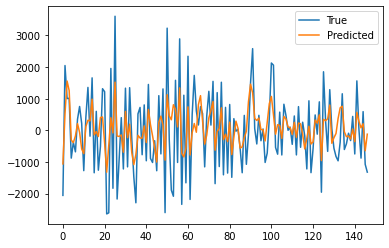

In [22]:
plt.plot(error_test, label='True')
plt.plot(error_test_pred, label='Predicted')
plt.legend()

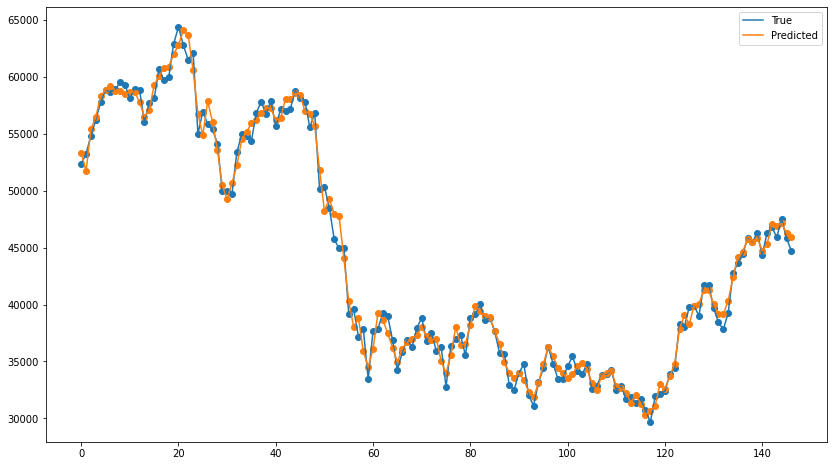

In [23]:
test_close_prices_final_pred = test_close_prices_pred + error_test_pred

plt.figure(figsize=(14, 8))
plt.plot(test_close_prices, label='True')
plt.plot(test_close_prices_final_pred, label='Predicted')
plt.scatter(np.arange(test_close_prices.shape[0]), test_close_prices)
plt.scatter(np.arange(test_close_prices.shape[0]), test_close_prices_final_pred)
plt.legend()

In [24]:
print(f'Test set MAE: {mean_absolute_error(test_close_prices, test_close_prices_final_pred)}')
print(f'Test set MAPE: {mean_absolute_percentage_error(test_close_prices, test_close_prices_final_pred)}')

Test set MAE: 789.9465021669477
Test set MAPE: 0.018260416784129565


**Best Result so far: MAPE = 0.0171**

## d_poc_p + total volume

In [25]:
prof = np.array(profiles[:-1])[:, :, -1]
prof.shape

(999, 20)

In [26]:
input_size = 20
prof = np.array(profiles[:-1])[:, :, -1]

minmax_d_poc_p = MinMaxScaler()
d_poc_p_norm = np.squeeze(minmax_d_poc_p.fit_transform(np.expand_dims(d_poc_p, axis=-1)))

minmax_prof = MinMaxScaler()
prof_norm = minmax_prof.fit_transform(prof)
print(d_poc_p_norm.shape, prof_norm.shape)

(999,) (999, 20)


In [39]:
x_poc_train.shape

(832, 20, 1)

In [40]:
x_poc, y = prepare_prediction_data(d_poc_p_norm, input_size=input_size)
n_samples = x_poc.shape[0]
x_poc_train = np.expand_dims(x_poc[:int(n_samples * train_ratio), :], axis=-1)
x_poc_test = np.expand_dims(x_poc[int(n_samples * train_ratio):, :], axis=-1)
y_train = y[:int(n_samples * train_ratio)]
y_test = y[int(n_samples * train_ratio):]
print(x_poc.shape, x_poc_train.shape, x_poc_test.shape, y_train.shape, y_test.shape)

(979, 20) (832, 20, 1) (147, 20, 1) (832,) (147,)


In [41]:
x_prof = []
for i in range(prof_norm.shape[0] - input_size):
    x_prof.append(prof_norm[i:i + input_size, :])
x_prof = np.array(x_prof)
n_samples = x_prof.shape[0]
x_prof_train = x_prof[:int(n_samples * train_ratio), :]
x_prof_test = x_prof[int(n_samples * train_ratio):, :]
print(x_prof.shape, x_prof_train.shape, x_prof_test.shape)

(979, 20, 20) (832, 20, 20) (147, 20, 20)


In [42]:
input_1 = Input(shape=x_poc_train.shape[1:])
l_1 = GRU(64, return_sequences=True)(input_1)
l_1 = GRU(16)(l_1)
l_1 = Dense(4, activation='relu')(l_1)

input_2 = Input(shape=x_prof_train.shape[1:])
l_2 = GRU(64, return_sequences=True)(input_2)
l_2 = GRU(16)(l_2)
l_2 = Dense(4, activation='relu')(l_2)

l = Concatenate()([l_1, l_2])
l = Dropout(0.5)(l)
l = Dense(1, activation='sigmoid')(l)

model = Model(inputs=[input_1, input_2], outputs=l)
model.compile(optimizer="adam", loss='mse')

ea = EarlyStopping(patience=50)
cp = ModelCheckpoint('saved_models/gru_d_poc_1d.h5')
cb = [ea, cp]

history = model.fit([x_poc_train, x_prof_train], y_train, batch_size=32, epochs=200, callbacks=cb, validation_split=0.3)

Epoch 1/200
19/19 [==============================] - 4s 48ms/step - loss: 0.0115 - val_loss: 0.0099
Epoch 2/200
19/19 [==============================] - 0s 15ms/step - loss: 0.0105 - val_loss: 0.0100
Epoch 3/200
19/19 [==============================] - 0s 18ms/step - loss: 0.0103 - val_loss: 0.0100
Epoch 4/200
19/19 [==============================] - 0s 13ms/step - loss: 0.0100 - val_loss: 0.0105
Epoch 5/200
19/19 [==============================] - 0s 15ms/step - loss: 0.0101 - val_loss: 0.0118
Epoch 6/200
19/19 [==============================] - 0s 15ms/step - loss: 0.0098 - val_loss: 0.0102
Epoch 7/200
19/19 [==============================] - 0s 15ms/step - loss: 0.0094 - val_loss: 0.0108
Epoch 8/200
19/19 [==============================] - 0s 15ms/step - loss: 0.0094 - val_loss: 0.0103
Epoch 9/200
19/19 [==============================] - 0s 15ms/step - loss: 0.0099 - val_loss: 0.0111
Epoch 10/200
19/19 [==============================] - 0s 16ms/step - loss: 0.0093 - val_loss: 0.0104

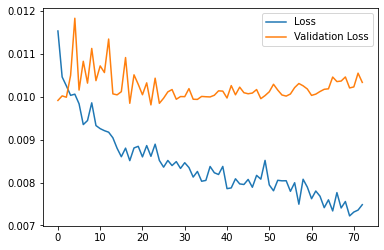

In [43]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [44]:
y_test_pred = np.squeeze(minmax_d_poc_p.inverse_transform(model.predict([x_poc_test, x_prof_test])))
y_train_pred = np.squeeze(minmax_d_poc_p.inverse_transform(model.predict([x_poc_train, x_prof_train])))

In [45]:
test_open_prices = np.array(pocs)[-y_test_pred.shape[0] - 1:-1]
test_close_prices = np.array(pocs)[-y_test_pred.shape[0]:]
train_open_prices = np.array(pocs)[input_size:-y_test_pred.shape[0] - 1]
train_close_prices = np.array(pocs)[input_size + 1:-y_test_pred.shape[0]]

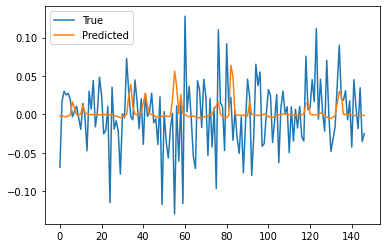

In [46]:
x, y = prepare_prediction_data(d_poc_p, input_size=input_size)
n_samples = x.shape[0]
y_test = y[int(n_samples * train_ratio):]

plt.plot(y_test, label='True')
plt.plot(y_test_pred, label='Predicted')
plt.legend()

In [47]:
d_poc_p_test = y_test_pred
d_poc_test = d_poc_p_test * test_open_prices
test_close_prices_pred = test_open_prices + d_poc_test

d_poc_p_train = y_train_pred
d_poc_train = d_poc_p_train * train_open_prices
train_close_prices_pred = train_open_prices + d_poc_train

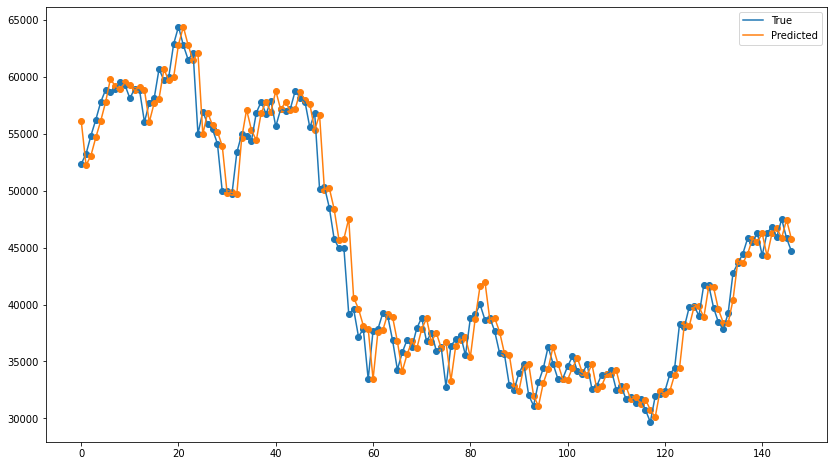

In [48]:
plt.figure(figsize=(14, 8))
plt.plot(test_close_prices, label='True')
plt.plot(test_close_prices_pred, label='Predicted')
plt.scatter(np.arange(test_close_prices.shape[0]), test_close_prices)
plt.scatter(np.arange(test_close_prices.shape[0]), test_close_prices_pred)
plt.legend()

In [49]:
print(f'Test set MAE: {mean_absolute_error(test_close_prices, test_close_prices_pred)}')
print(f'Test set MAPE: {mean_absolute_percentage_error(test_close_prices, test_close_prices_pred)}')

Test set MAE: 1409.9651790620528
Test set MAPE: 0.03325797037974708


In [50]:
error_train = train_close_prices - train_close_prices_pred
error_test = test_close_prices - test_close_prices_pred
print(error_train.shape, error_test.shape)

(832,) (147,)


In [51]:
n_test_samples = error_test.shape[0]
all_error = np.concatenate((error_train, error_test))
all_error.shape

(979,)

In [52]:
ceemdan = CEEMDAN()
error_imfs = ceemdan.ceemdan(all_error).T
error_imfs.shape

(979, 8)

In [53]:
input_size = 20
test_pred = []
for i in range(error_imfs.shape[1]):
    print(f'*** IMF {i + 1} / {error_imfs.shape[1]} ***')
    minmax = MinMaxScaler()
    data_norm = np.squeeze(minmax.fit_transform(np.expand_dims(error_imfs[:, i], axis=-1)))
    x, y = prepare_prediction_data(data_norm, input_size=input_size)
    n_samples = x.shape[0]
    x_train = np.expand_dims(x[:-n_test_samples, :], axis=-1)
    x_test = np.expand_dims(x[-n_test_samples:, :], axis=-1)
    y_train = y[:-n_test_samples]
    y_test = y[-n_test_samples:]
    
    model = rnn_gru(input_size=input_size)
    ea = EarlyStopping(patience=20)
    cp = ModelCheckpoint('saved_models/gru_d_oc_p_1d.h5')
    cb = [ea, cp]
    history = model.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=cb, validation_split=0.3)
    
    print(f'Test set MSE: {model.evaluate(x_test, y_test, verbose=0)}')
    y_test_pred = np.squeeze(minmax.inverse_transform(model.predict(x_test)))
    test_pred.append(y_test_pred)

*** IMF 1 / 8 ***
Epoch 1/100
18/18 [==============================] - 4s 49ms/step - loss: 9.4063e-04 - val_loss: 0.0199
Epoch 2/100
18/18 [==============================] - 0s 18ms/step - loss: 8.3732e-04 - val_loss: 0.0199
Epoch 3/100
18/18 [==============================] - 1s 29ms/step - loss: 8.3804e-04 - val_loss: 0.0199
Epoch 4/100
18/18 [==============================] - 0s 23ms/step - loss: 8.2849e-04 - val_loss: 0.0198
Epoch 5/100
18/18 [==============================] - 0s 26ms/step - loss: 8.3136e-04 - val_loss: 0.0198
Epoch 6/100
18/18 [==============================] - 0s 27ms/step - loss: 8.3024e-04 - val_loss: 0.0198
Epoch 7/100
18/18 [==============================] - 1s 35ms/step - loss: 8.6499e-04 - val_loss: 0.0197
Epoch 8/100
18/18 [==============================] - 0s 27ms/step - loss: 8.4350e-04 - val_loss: 0.0197
Epoch 9/100
18/18 [==============================] - 0s 26ms/step - loss: 8.3297e-04 - val_loss: 0.0197
Epoch 10/100
18/18 [==========================

Epoch 79/100
18/18 [==============================] - 1s 29ms/step - loss: 6.5876e-04 - val_loss: 0.0149
Epoch 80/100
18/18 [==============================] - 0s 26ms/step - loss: 6.6096e-04 - val_loss: 0.0149
Epoch 81/100
18/18 [==============================] - 1s 29ms/step - loss: 6.6987e-04 - val_loss: 0.0149
Epoch 82/100
18/18 [==============================] - 0s 23ms/step - loss: 6.6503e-04 - val_loss: 0.0150
Epoch 83/100
18/18 [==============================] - 0s 23ms/step - loss: 6.5529e-04 - val_loss: 0.0148
Epoch 84/100
18/18 [==============================] - 0s 24ms/step - loss: 6.6932e-04 - val_loss: 0.0149
Epoch 85/100
18/18 [==============================] - 0s 23ms/step - loss: 6.6914e-04 - val_loss: 0.0149
Epoch 86/100
18/18 [==============================] - 0s 22ms/step - loss: 6.5929e-04 - val_loss: 0.0148
Epoch 87/100
18/18 [==============================] - 0s 26ms/step - loss: 6.8092e-04 - val_loss: 0.0150
Epoch 88/100
18/18 [==============================] - 1

18/18 [==============================] - 0s 23ms/step - loss: 6.1974e-05 - val_loss: 0.0021
Epoch 57/100
18/18 [==============================] - 0s 25ms/step - loss: 6.3864e-05 - val_loss: 0.0021
Epoch 58/100
18/18 [==============================] - 0s 24ms/step - loss: 6.8010e-05 - val_loss: 0.0021
Epoch 59/100
18/18 [==============================] - 0s 23ms/step - loss: 6.6407e-05 - val_loss: 0.0021
Epoch 60/100
18/18 [==============================] - 0s 25ms/step - loss: 6.3389e-05 - val_loss: 0.0020
Epoch 61/100
18/18 [==============================] - 0s 26ms/step - loss: 6.1521e-05 - val_loss: 0.0020
Epoch 62/100
18/18 [==============================] - 1s 32ms/step - loss: 6.3397e-05 - val_loss: 0.0020
Epoch 63/100
18/18 [==============================] - 0s 25ms/step - loss: 6.3641e-05 - val_loss: 0.0020
Epoch 64/100
18/18 [==============================] - 0s 25ms/step - loss: 6.0959e-05 - val_loss: 0.0020
Epoch 65/100
18/18 [==============================] - 0s 25ms/step -

18/18 [==============================] - 0s 24ms/step - loss: 8.1602e-05 - val_loss: 0.0011
Epoch 35/100
18/18 [==============================] - 0s 25ms/step - loss: 8.4718e-05 - val_loss: 9.9427e-04
Epoch 36/100
18/18 [==============================] - 0s 25ms/step - loss: 1.0895e-04 - val_loss: 9.8872e-04
Epoch 37/100
18/18 [==============================] - 0s 23ms/step - loss: 7.7132e-05 - val_loss: 8.8863e-04
Epoch 38/100
18/18 [==============================] - 0s 24ms/step - loss: 1.0037e-04 - val_loss: 9.7148e-04
Epoch 39/100
18/18 [==============================] - 0s 26ms/step - loss: 6.8627e-05 - val_loss: 9.1400e-04
Epoch 40/100
18/18 [==============================] - 0s 25ms/step - loss: 8.1438e-05 - val_loss: 0.0011
Epoch 41/100
18/18 [==============================] - 0s 27ms/step - loss: 6.4071e-05 - val_loss: 9.2323e-04
Epoch 42/100
18/18 [==============================] - 0s 24ms/step - loss: 6.1120e-05 - val_loss: 8.2959e-04
Epoch 43/100
18/18 [====================

18/18 [==============================] - 0s 25ms/step - loss: 5.8136e-04 - val_loss: 0.0152
Epoch 10/100
18/18 [==============================] - 0s 24ms/step - loss: 5.9139e-04 - val_loss: 0.0145
Epoch 11/100
18/18 [==============================] - 0s 26ms/step - loss: 5.5788e-04 - val_loss: 0.0138
Epoch 12/100
18/18 [==============================] - 0s 23ms/step - loss: 4.9840e-04 - val_loss: 0.0129
Epoch 13/100
18/18 [==============================] - 0s 23ms/step - loss: 4.6302e-04 - val_loss: 0.0118
Epoch 14/100
18/18 [==============================] - 0s 23ms/step - loss: 4.0126e-04 - val_loss: 0.0099
Epoch 15/100
18/18 [==============================] - 0s 23ms/step - loss: 3.2163e-04 - val_loss: 0.0074
Epoch 16/100
18/18 [==============================] - 0s 24ms/step - loss: 2.5240e-04 - val_loss: 0.0052
Epoch 17/100
18/18 [==============================] - 0s 23ms/step - loss: 1.5976e-04 - val_loss: 0.0037
Epoch 18/100
18/18 [==============================] - 0s 24ms/step -

Epoch 87/100
18/18 [==============================] - 0s 24ms/step - loss: 1.1773e-05 - val_loss: 9.4172e-04
Epoch 88/100
18/18 [==============================] - 0s 23ms/step - loss: 1.3420e-05 - val_loss: 9.4413e-04
Epoch 89/100
18/18 [==============================] - 0s 25ms/step - loss: 1.3878e-05 - val_loss: 8.7466e-04
Epoch 90/100
18/18 [==============================] - 0s 23ms/step - loss: 1.1544e-05 - val_loss: 9.2478e-04
Epoch 91/100
18/18 [==============================] - 0s 23ms/step - loss: 1.1605e-05 - val_loss: 9.0413e-04
Epoch 92/100
18/18 [==============================] - 0s 24ms/step - loss: 1.2778e-05 - val_loss: 9.2427e-04
Epoch 93/100
18/18 [==============================] - 0s 24ms/step - loss: 1.3283e-05 - val_loss: 9.5734e-04
Epoch 94/100
18/18 [==============================] - 0s 23ms/step - loss: 1.3847e-05 - val_loss: 9.0041e-04
Epoch 95/100
18/18 [==============================] - 0s 24ms/step - loss: 8.9479e-06 - val_loss: 8.8618e-04
Epoch 96/100
18/18 

18/18 [==============================] - 0s 24ms/step - loss: 1.3435e-05 - val_loss: 0.0012
Epoch 65/100
18/18 [==============================] - 0s 23ms/step - loss: 8.3675e-06 - val_loss: 0.0012
Epoch 66/100
18/18 [==============================] - 0s 25ms/step - loss: 9.3046e-06 - val_loss: 0.0012
Epoch 67/100
18/18 [==============================] - 0s 24ms/step - loss: 6.5478e-06 - val_loss: 0.0012
Epoch 68/100
18/18 [==============================] - 1s 30ms/step - loss: 7.2805e-06 - val_loss: 0.0013
Epoch 69/100
18/18 [==============================] - 0s 25ms/step - loss: 1.4598e-05 - val_loss: 0.0012
Epoch 70/100
18/18 [==============================] - 0s 24ms/step - loss: 1.4823e-05 - val_loss: 0.0013
Epoch 71/100
18/18 [==============================] - 0s 25ms/step - loss: 9.3629e-06 - val_loss: 0.0012
Epoch 72/100
18/18 [==============================] - 0s 24ms/step - loss: 7.8812e-06 - val_loss: 0.0012
Epoch 73/100
18/18 [==============================] - 0s 25ms/step -

Epoch 41/100
18/18 [==============================] - 0s 23ms/step - loss: 1.7639e-06 - val_loss: 6.6149e-04
Epoch 42/100
18/18 [==============================] - 0s 23ms/step - loss: 1.8891e-06 - val_loss: 6.6363e-04
Epoch 43/100
18/18 [==============================] - 0s 26ms/step - loss: 2.4366e-06 - val_loss: 6.4845e-04
Epoch 44/100
18/18 [==============================] - 0s 26ms/step - loss: 2.1720e-06 - val_loss: 6.0773e-04
Epoch 45/100
18/18 [==============================] - 0s 25ms/step - loss: 1.6314e-06 - val_loss: 6.3186e-04
Epoch 46/100
18/18 [==============================] - 1s 30ms/step - loss: 2.0709e-06 - val_loss: 5.7692e-04
Epoch 47/100
18/18 [==============================] - 0s 27ms/step - loss: 2.7368e-06 - val_loss: 6.3800e-04
Epoch 48/100
18/18 [==============================] - 0s 26ms/step - loss: 4.0196e-06 - val_loss: 5.8431e-04
Epoch 49/100
18/18 [==============================] - 0s 26ms/step - loss: 1.6088e-06 - val_loss: 5.4292e-04
Epoch 50/100
18/18 

18/18 [==============================] - 0s 24ms/step - loss: 1.3371e-04 - val_loss: 0.0040
Epoch 17/100
18/18 [==============================] - 0s 22ms/step - loss: 1.3828e-04 - val_loss: 0.0041
Epoch 18/100
18/18 [==============================] - 0s 25ms/step - loss: 1.2181e-04 - val_loss: 0.0037
Epoch 19/100
18/18 [==============================] - 0s 25ms/step - loss: 1.1386e-04 - val_loss: 0.0039
Epoch 20/100
18/18 [==============================] - 0s 25ms/step - loss: 1.1958e-04 - val_loss: 0.0040
Epoch 21/100
18/18 [==============================] - 0s 24ms/step - loss: 1.0981e-04 - val_loss: 0.0039
Epoch 22/100
18/18 [==============================] - 0s 24ms/step - loss: 9.9099e-05 - val_loss: 0.0033
Epoch 23/100
18/18 [==============================] - 0s 26ms/step - loss: 9.8029e-05 - val_loss: 0.0032
Epoch 24/100
18/18 [==============================] - 0s 26ms/step - loss: 9.3198e-05 - val_loss: 0.0034
Epoch 25/100
18/18 [==============================] - 0s 23ms/step -

18/18 [==============================] - 1s 34ms/step - loss: 1.2275e-06 - val_loss: 0.0010
Epoch 95/100
18/18 [==============================] - 1s 29ms/step - loss: 1.1031e-06 - val_loss: 0.0011
Epoch 96/100
18/18 [==============================] - 0s 25ms/step - loss: 1.3696e-06 - val_loss: 0.0010
Epoch 97/100
18/18 [==============================] - 0s 27ms/step - loss: 1.2659e-06 - val_loss: 0.0011
Epoch 98/100
18/18 [==============================] - 0s 24ms/step - loss: 1.0926e-06 - val_loss: 0.0010
Epoch 99/100
18/18 [==============================] - 0s 23ms/step - loss: 1.3153e-06 - val_loss: 0.0010
Epoch 100/100
18/18 [==============================] - 0s 25ms/step - loss: 1.3247e-06 - val_loss: 0.0011
Test set MSE: 0.005191048141568899
*** IMF 8 / 8 ***
Epoch 1/100
18/18 [==============================] - 3s 46ms/step - loss: 0.0624 - val_loss: 0.1882
Epoch 2/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0244 - val_loss: 0.1888
Epoch 3/100
18/18 [=====

In [54]:
error_test_pred = np.sum(np.array(test_pred).T, axis=1)
error_test_pred.shape

(147,)

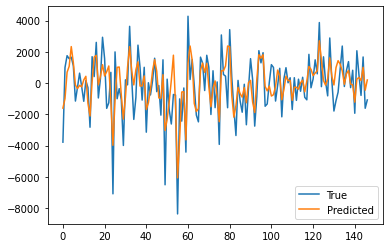

In [55]:
plt.plot(error_test, label='True')
plt.plot(error_test_pred, label='Predicted')
plt.legend()

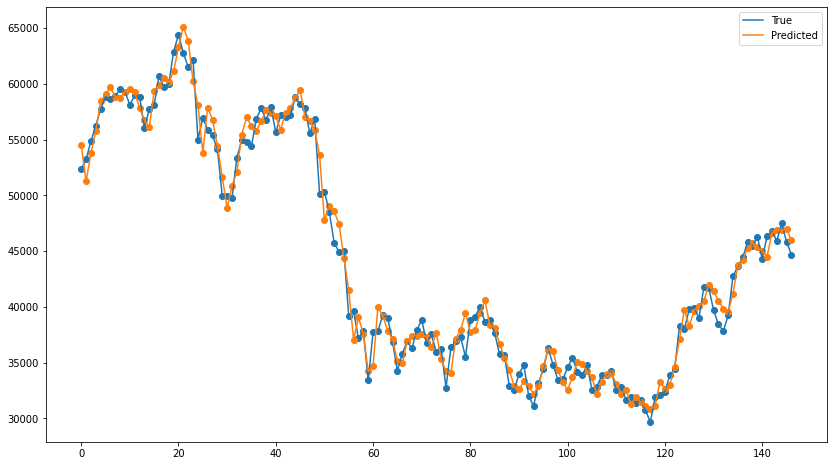

In [56]:
test_close_prices_final_pred = test_close_prices_pred + error_test_pred

plt.figure(figsize=(14, 8))
plt.plot(test_close_prices, label='True')
plt.plot(test_close_prices_final_pred, label='Predicted')
plt.scatter(np.arange(test_close_prices.shape[0]), test_close_prices)
plt.scatter(np.arange(test_close_prices.shape[0]), test_close_prices_final_pred)
plt.legend()

In [57]:
print(f'Test set MAE: {mean_absolute_error(test_close_prices, test_close_prices_final_pred)}')
print(f'Test set MAPE: {mean_absolute_percentage_error(test_close_prices, test_close_prices_final_pred)}')

Test set MAE: 1078.9020622901758
Test set MAPE: 0.02505544068581059


## d_poc_p + total volume + EMD

In [58]:
ceemdan = CEEMDAN()
imfs = ceemdan.ceemdan(d_poc_p).T
imfs.shape

(999, 9)

In [59]:
input_size = 20

minmax_prof = MinMaxScaler()
prof_norm = minmax_prof.fit_transform(prof)

x_prof = []
for i in range(prof_norm.shape[0] - input_size):
    x_prof.append(prof_norm[i:i + input_size, :])
x_prof = np.array(x_prof)
n_samples = x_prof.shape[0]
x_prof_train = x_prof[:int(n_samples * train_ratio), :]
x_prof_test = x_prof[int(n_samples * train_ratio):, :]
print(x_prof.shape, x_prof_train.shape, x_prof_test.shape)

(979, 20, 20) (832, 20, 20) (147, 20, 20)


In [60]:
train_pred = []
test_pred = []
for i in range(imfs.shape[1]):
    print(f'*** IMF {i + 1} / {imfs.shape[1]} ***')
    minmax = MinMaxScaler()
    data_norm = np.squeeze(minmax.fit_transform(np.expand_dims(imfs[:, i], axis=-1)))
    x_poc, y = prepare_prediction_data(data_norm, input_size=input_size)
    n_samples = x_poc.shape[0]
    x_poc_train = np.expand_dims(x_poc[:int(n_samples * train_ratio), :], axis=-1)
    x_poc_test = np.expand_dims(x_poc[int(n_samples * train_ratio):, :], axis=-1)
    y_train = y[:int(n_samples * train_ratio)]
    y_test = y[int(n_samples * train_ratio):]
    
    input_1 = Input(shape=x_poc_train.shape[1:])
    l_1 = GRU(64, return_sequences=True)(input_1)
    l_1 = GRU(16)(l_1)
    l_1 = Dense(4, activation='relu')(l_1)

    input_2 = Input(shape=x_prof_train.shape[1:])
    l_2 = GRU(64, return_sequences=True)(input_2)
    l_2 = GRU(16)(l_2)
    l_2 = Dense(4, activation='relu')(l_2)

    l = Concatenate()([l_1, l_2])
    l = Dropout(0.5)(l)
    l = Dense(1, activation='sigmoid')(l)

    model = Model(inputs=[input_1, input_2], outputs=l)
    model.compile(optimizer="adam", loss='mse')

    ea = EarlyStopping(patience=20)
    cp = ModelCheckpoint('saved_models/gru_d_poc_1d.h5')
    cb = [ea, cp]

    history = model.fit([x_poc_train, x_prof_train], y_train, batch_size=32, epochs=100, callbacks=cb, validation_split=0.3)
    
    print(f'Test set MSE: {model.evaluate([x_poc_test, x_prof_test], y_test, verbose=0)}')
    y_test_pred = np.squeeze(minmax.inverse_transform(model.predict([x_poc_test, x_prof_test])))
    test_pred.append(y_test_pred)
    
    y_train_pred = np.squeeze(minmax.inverse_transform(model.predict([x_poc_train, x_prof_train])))
    train_pred.append(y_train_pred)
    
    backend.clear_session()

*** IMF 1 / 9 ***
Epoch 1/100
19/19 [==============================] - 6s 77ms/step - loss: 0.0173 - val_loss: 0.0198
Epoch 2/100
19/19 [==============================] - 0s 24ms/step - loss: 0.0169 - val_loss: 0.0199
Epoch 3/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0170 - val_loss: 0.0198
Epoch 4/100
19/19 [==============================] - 1s 44ms/step - loss: 0.0169 - val_loss: 0.0202
Epoch 5/100
19/19 [==============================] - 2s 85ms/step - loss: 0.0169 - val_loss: 0.0197
Epoch 6/100
19/19 [==============================] - 2s 80ms/step - loss: 0.0169 - val_loss: 0.0199
Epoch 7/100
19/19 [==============================] - 2s 82ms/step - loss: 0.0168 - val_loss: 0.0197
Epoch 8/100
19/19 [==============================] - 1s 58ms/step - loss: 0.0168 - val_loss: 0.0197
Epoch 9/100
19/19 [==============================] - 1s 59ms/step - loss: 0.0164 - val_loss: 0.0195
Epoch 10/100
19/19 [==============================] - 1s 65ms/step - loss: 0.0167 

19/19 [==============================] - 5s 75ms/step - loss: 0.0111 - val_loss: 0.0140
Epoch 2/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0109 - val_loss: 0.0139
Epoch 3/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0109 - val_loss: 0.0140
Epoch 4/100
19/19 [==============================] - 1s 32ms/step - loss: 0.0109 - val_loss: 0.0140
Epoch 5/100
19/19 [==============================] - 1s 39ms/step - loss: 0.0108 - val_loss: 0.0139
Epoch 6/100
19/19 [==============================] - 1s 34ms/step - loss: 0.0107 - val_loss: 0.0140
Epoch 7/100
19/19 [==============================] - 1s 40ms/step - loss: 0.0107 - val_loss: 0.0139
Epoch 8/100
19/19 [==============================] - 1s 49ms/step - loss: 0.0108 - val_loss: 0.0139
Epoch 9/100
19/19 [==============================] - 1s 47ms/step - loss: 0.0106 - val_loss: 0.0139
Epoch 10/100
19/19 [==============================] - 1s 41ms/step - loss: 0.0107 - val_loss: 0.0139
Epoch 11/10

Epoch 28/100
19/19 [==============================] - 1s 45ms/step - loss: 0.0108 - val_loss: 0.0052
Epoch 29/100
19/19 [==============================] - 1s 39ms/step - loss: 0.0101 - val_loss: 0.0051
Epoch 30/100
19/19 [==============================] - 1s 37ms/step - loss: 0.0112 - val_loss: 0.0052
Epoch 31/100
19/19 [==============================] - 1s 33ms/step - loss: 0.0103 - val_loss: 0.0052
Epoch 32/100
19/19 [==============================] - 1s 41ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 33/100
19/19 [==============================] - 1s 43ms/step - loss: 0.0090 - val_loss: 0.0053
Epoch 34/100
19/19 [==============================] - 1s 37ms/step - loss: 0.0096 - val_loss: 0.0056
Epoch 35/100
19/19 [==============================] - 1s 48ms/step - loss: 0.0107 - val_loss: 0.0050
Epoch 36/100
19/19 [==============================] - 1s 43ms/step - loss: 0.0095 - val_loss: 0.0064
Epoch 37/100
19/19 [==============================] - 1s 35ms/step - loss: 0.0094 - val_los

19/19 [==============================] - 1s 42ms/step - loss: 0.0151 - val_loss: 0.0252
Epoch 17/100
19/19 [==============================] - 1s 41ms/step - loss: 0.0163 - val_loss: 0.0243
Epoch 18/100
19/19 [==============================] - 1s 33ms/step - loss: 0.0144 - val_loss: 0.0267
Epoch 19/100
19/19 [==============================] - 1s 40ms/step - loss: 0.0160 - val_loss: 0.0270
Epoch 20/100
19/19 [==============================] - 1s 44ms/step - loss: 0.0147 - val_loss: 0.0267
Epoch 21/100
19/19 [==============================] - 1s 37ms/step - loss: 0.0149 - val_loss: 0.0234
Epoch 22/100
19/19 [==============================] - 1s 56ms/step - loss: 0.0144 - val_loss: 0.0271
Epoch 23/100
19/19 [==============================] - 1s 38ms/step - loss: 0.0161 - val_loss: 0.0262
Epoch 24/100
19/19 [==============================] - 1s 35ms/step - loss: 0.0148 - val_loss: 0.0255
Epoch 25/100
19/19 [==============================] - 1s 41ms/step - loss: 0.0145 - val_loss: 0.0302
Epo

19/19 [==============================] - 1s 46ms/step - loss: 0.0323 - val_loss: 0.0573
Epoch 40/100
19/19 [==============================] - 1s 36ms/step - loss: 0.0297 - val_loss: 0.0289
Epoch 41/100
19/19 [==============================] - 1s 36ms/step - loss: 0.0275 - val_loss: 0.0280
Epoch 42/100
19/19 [==============================] - 1s 39ms/step - loss: 0.0287 - val_loss: 0.0285
Epoch 43/100
19/19 [==============================] - 1s 35ms/step - loss: 0.0299 - val_loss: 0.0773
Epoch 44/100
19/19 [==============================] - 1s 35ms/step - loss: 0.0300 - val_loss: 0.0781
Epoch 45/100
19/19 [==============================] - 1s 35ms/step - loss: 0.0280 - val_loss: 0.0594
Epoch 46/100
19/19 [==============================] - 1s 42ms/step - loss: 0.0277 - val_loss: 0.0793
Epoch 47/100
19/19 [==============================] - 1s 42ms/step - loss: 0.0245 - val_loss: 0.0170
Epoch 48/100
19/19 [==============================] - 1s 37ms/step - loss: 0.0316 - val_loss: 0.0874
Epo

In [61]:
y_test_pred = np.sum(np.array(test_pred).T, axis=1)
y_train_pred = np.sum(np.array(train_pred).T, axis=1)
print(y_test_pred.shape, y_train_pred.shape)

(147,) (832,)


In [62]:
test_open_prices = np.array(pocs)[-y_test_pred.shape[0] - 1:-1]
test_close_prices = np.array(pocs)[-y_test_pred.shape[0]:]
train_open_prices = np.array(pocs)[input_size:-y_test_pred.shape[0] - 1]
train_close_prices = np.array(pocs)[input_size + 1:-y_test_pred.shape[0]]

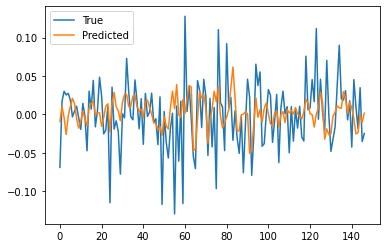

In [63]:
x, y = prepare_prediction_data(d_poc_p, input_size=input_size)
n_samples = x.shape[0]
y_test = y[int(n_samples * train_ratio):]

plt.plot(y_test, label='True')
plt.plot(y_test_pred, label='Predicted')
plt.legend()

In [64]:
d_poc_p_test = y_test_pred
d_poc_test = d_poc_p_test * test_open_prices
test_close_prices_pred = test_open_prices + d_poc_test

d_poc_p_train = y_train_pred
d_poc_train = d_poc_p_train * train_open_prices
train_close_prices_pred = train_open_prices + d_poc_train

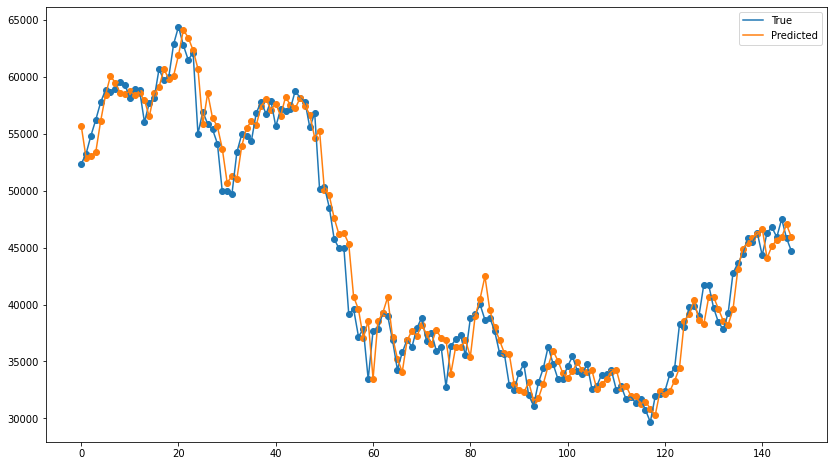

In [65]:
plt.figure(figsize=(14, 8))
plt.plot(test_close_prices, label='True')
plt.plot(test_close_prices_pred, label='Predicted')
plt.scatter(np.arange(test_close_prices.shape[0]), test_close_prices)
plt.scatter(np.arange(test_close_prices.shape[0]), test_close_prices_pred)
plt.legend()

In [66]:
print(f'Test set MAE: {mean_absolute_error(test_close_prices, test_close_prices_pred)}')
print(f'Test set MAPE: {mean_absolute_percentage_error(test_close_prices, test_close_prices_pred)}')

Test set MAE: 1324.1021368952343
Test set MAPE: 0.031164766630650622


In [67]:
error_train = train_close_prices - train_close_prices_pred
error_test = test_close_prices - test_close_prices_pred
print(error_train.shape, error_test.shape)

(832,) (147,)


In [68]:
n_test_samples = error_test.shape[0]
all_error = np.concatenate((error_train, error_test))
all_error.shape

(979,)

In [69]:
ceemdan = CEEMDAN()
error_imfs = ceemdan.ceemdan(all_error).T
error_imfs.shape

(979, 9)

In [70]:
input_size = 20
test_pred = []
for i in range(error_imfs.shape[1]):
    print(f'*** IMF {i + 1} / {error_imfs.shape[1]} ***')
    minmax = MinMaxScaler()
    data_norm = np.squeeze(minmax.fit_transform(np.expand_dims(error_imfs[:, i], axis=-1)))
    x, y = prepare_prediction_data(data_norm, input_size=input_size)
    n_samples = x.shape[0]
    x_train = np.expand_dims(x[:-n_test_samples, :], axis=-1)
    x_test = np.expand_dims(x[-n_test_samples:, :], axis=-1)
    y_train = y[:-n_test_samples]
    y_test = y[-n_test_samples:]
    
    model = rnn_gru(input_size=input_size)
    ea = EarlyStopping(patience=20)
    cp = ModelCheckpoint('saved_models/gru_d_oc_p_1d.h5')
    cb = [ea, cp]
    history = model.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=cb, validation_split=0.3)
    
    print(f'Test set MSE: {model.evaluate(x_test, y_test, verbose=0)}')
    y_test_pred = np.squeeze(minmax.inverse_transform(model.predict(x_test)))
    test_pred.append(y_test_pred)

*** IMF 1 / 9 ***
Epoch 1/100
18/18 [==============================] - 4s 47ms/step - loss: 8.0902e-04 - val_loss: 0.0213
Epoch 2/100
18/18 [==============================] - 0s 21ms/step - loss: 7.6513e-04 - val_loss: 0.0212
Epoch 3/100
18/18 [==============================] - 0s 20ms/step - loss: 7.5528e-04 - val_loss: 0.0212
Epoch 4/100
18/18 [==============================] - 0s 23ms/step - loss: 7.5422e-04 - val_loss: 0.0212
Epoch 5/100
18/18 [==============================] - 0s 22ms/step - loss: 7.7652e-04 - val_loss: 0.0212
Epoch 6/100
18/18 [==============================] - 0s 23ms/step - loss: 7.5237e-04 - val_loss: 0.0211
Epoch 7/100
18/18 [==============================] - 0s 28ms/step - loss: 8.2683e-04 - val_loss: 0.0211
Epoch 8/100
18/18 [==============================] - 1s 33ms/step - loss: 7.7346e-04 - val_loss: 0.0211
Epoch 9/100
18/18 [==============================] - 1s 33ms/step - loss: 7.6713e-04 - val_loss: 0.0210
Epoch 10/100
18/18 [==========================

Epoch 79/100
18/18 [==============================] - 1s 30ms/step - loss: 6.4293e-04 - val_loss: 0.0171
Epoch 80/100
18/18 [==============================] - 1s 30ms/step - loss: 6.3780e-04 - val_loss: 0.0171
Epoch 81/100
18/18 [==============================] - 1s 28ms/step - loss: 6.4079e-04 - val_loss: 0.0171
Epoch 82/100
18/18 [==============================] - 1s 30ms/step - loss: 6.3913e-04 - val_loss: 0.0171
Epoch 83/100
18/18 [==============================] - 1s 45ms/step - loss: 6.4511e-04 - val_loss: 0.0171
Epoch 84/100
18/18 [==============================] - 1s 32ms/step - loss: 6.4490e-04 - val_loss: 0.0170
Epoch 85/100
18/18 [==============================] - 1s 35ms/step - loss: 6.4235e-04 - val_loss: 0.0171
Epoch 86/100
18/18 [==============================] - 1s 33ms/step - loss: 6.4204e-04 - val_loss: 0.0171
Epoch 87/100
18/18 [==============================] - 1s 36ms/step - loss: 6.3970e-04 - val_loss: 0.0170
Epoch 88/100
18/18 [==============================] - 1

18/18 [==============================] - 1s 32ms/step - loss: 5.1824e-05 - val_loss: 0.0032
Epoch 57/100
18/18 [==============================] - 1s 33ms/step - loss: 4.9628e-05 - val_loss: 0.0030
Epoch 58/100
18/18 [==============================] - 1s 32ms/step - loss: 5.2667e-05 - val_loss: 0.0030
Epoch 59/100
18/18 [==============================] - 1s 33ms/step - loss: 5.4585e-05 - val_loss: 0.0030
Epoch 60/100
18/18 [==============================] - 1s 32ms/step - loss: 5.3219e-05 - val_loss: 0.0030
Epoch 61/100
18/18 [==============================] - 1s 31ms/step - loss: 5.9832e-05 - val_loss: 0.0030
Epoch 62/100
18/18 [==============================] - 1s 30ms/step - loss: 5.1647e-05 - val_loss: 0.0029
Epoch 63/100
18/18 [==============================] - 1s 28ms/step - loss: 4.8288e-05 - val_loss: 0.0030
Epoch 64/100
18/18 [==============================] - 1s 28ms/step - loss: 4.9421e-05 - val_loss: 0.0030
Epoch 65/100
18/18 [==============================] - 0s 25ms/step -

18/18 [==============================] - 0s 26ms/step - loss: 6.3467e-05 - val_loss: 0.0011
Epoch 34/100
18/18 [==============================] - 1s 38ms/step - loss: 6.6681e-05 - val_loss: 0.0011
Epoch 35/100
18/18 [==============================] - 1s 33ms/step - loss: 5.3584e-05 - val_loss: 9.5649e-04
Epoch 36/100
18/18 [==============================] - 1s 31ms/step - loss: 5.1300e-05 - val_loss: 9.6282e-04
Epoch 37/100
18/18 [==============================] - 1s 39ms/step - loss: 5.0096e-05 - val_loss: 8.5643e-04
Epoch 38/100
18/18 [==============================] - 1s 38ms/step - loss: 5.0125e-05 - val_loss: 9.4262e-04
Epoch 39/100
18/18 [==============================] - 1s 38ms/step - loss: 4.3226e-05 - val_loss: 7.4824e-04
Epoch 40/100
18/18 [==============================] - 1s 38ms/step - loss: 4.2317e-05 - val_loss: 7.5997e-04
Epoch 41/100
18/18 [==============================] - 1s 37ms/step - loss: 3.4385e-05 - val_loss: 7.7286e-04
Epoch 42/100
18/18 [====================

18/18 [==============================] - 1s 43ms/step - loss: 5.7832e-04 - val_loss: 0.0233
Epoch 9/100
18/18 [==============================] - 1s 33ms/step - loss: 5.2108e-04 - val_loss: 0.0194
Epoch 10/100
18/18 [==============================] - 1s 30ms/step - loss: 4.6735e-04 - val_loss: 0.0150
Epoch 11/100
18/18 [==============================] - 0s 27ms/step - loss: 3.2500e-04 - val_loss: 0.0107
Epoch 12/100
18/18 [==============================] - 0s 27ms/step - loss: 1.8892e-04 - val_loss: 0.0077
Epoch 13/100
18/18 [==============================] - 0s 27ms/step - loss: 1.6427e-04 - val_loss: 0.0073
Epoch 14/100
18/18 [==============================] - 0s 25ms/step - loss: 1.4109e-04 - val_loss: 0.0065
Epoch 15/100
18/18 [==============================] - 0s 24ms/step - loss: 1.3621e-04 - val_loss: 0.0063
Epoch 16/100
18/18 [==============================] - 0s 26ms/step - loss: 1.2356e-04 - val_loss: 0.0063
Epoch 17/100
18/18 [==============================] - 0s 24ms/step - 

18/18 [==============================] - 0s 24ms/step - loss: 1.1514e-05 - val_loss: 0.0020
Epoch 87/100
18/18 [==============================] - 0s 23ms/step - loss: 9.7834e-06 - val_loss: 0.0020
Epoch 88/100
18/18 [==============================] - 0s 24ms/step - loss: 1.0415e-05 - val_loss: 0.0020
Epoch 89/100
18/18 [==============================] - 0s 23ms/step - loss: 1.1805e-05 - val_loss: 0.0020
Epoch 90/100
18/18 [==============================] - 0s 24ms/step - loss: 1.1439e-05 - val_loss: 0.0020
Epoch 91/100
18/18 [==============================] - 0s 23ms/step - loss: 1.7915e-05 - val_loss: 0.0019
Epoch 92/100
18/18 [==============================] - 0s 23ms/step - loss: 1.0862e-05 - val_loss: 0.0020
Epoch 93/100
18/18 [==============================] - 0s 22ms/step - loss: 1.5860e-05 - val_loss: 0.0020
Epoch 94/100
18/18 [==============================] - 0s 25ms/step - loss: 1.1337e-05 - val_loss: 0.0020
Epoch 95/100
18/18 [==============================] - 0s 24ms/step -

18/18 [==============================] - 0s 26ms/step - loss: 1.8229e-04 - val_loss: 0.0065
Epoch 20/100
18/18 [==============================] - 0s 24ms/step - loss: 1.0522e-04 - val_loss: 0.0026
Epoch 21/100
18/18 [==============================] - 0s 25ms/step - loss: 5.3405e-05 - val_loss: 9.1377e-04
Epoch 22/100
18/18 [==============================] - 0s 23ms/step - loss: 4.1381e-05 - val_loss: 9.9284e-04
Epoch 23/100
18/18 [==============================] - 0s 25ms/step - loss: 3.3787e-05 - val_loss: 9.2864e-04
Epoch 24/100
18/18 [==============================] - 0s 25ms/step - loss: 2.7455e-05 - val_loss: 8.8694e-04
Epoch 25/100
18/18 [==============================] - 1s 29ms/step - loss: 2.7827e-05 - val_loss: 0.0011
Epoch 26/100
18/18 [==============================] - 0s 27ms/step - loss: 5.2940e-05 - val_loss: 0.0010
Epoch 27/100
18/18 [==============================] - 0s 26ms/step - loss: 2.4069e-05 - val_loss: 6.8967e-04
Epoch 28/100
18/18 [============================

18/18 [==============================] - 0s 27ms/step - loss: 0.0029 - val_loss: 0.0073
Epoch 4/100
18/18 [==============================] - 0s 24ms/step - loss: 0.0019 - val_loss: 0.0066
Epoch 5/100
18/18 [==============================] - 0s 22ms/step - loss: 0.0016 - val_loss: 0.0067
Epoch 6/100
18/18 [==============================] - 0s 25ms/step - loss: 0.0014 - val_loss: 0.0072
Epoch 7/100
18/18 [==============================] - 0s 26ms/step - loss: 0.0012 - val_loss: 0.0068
Epoch 8/100
18/18 [==============================] - 0s 24ms/step - loss: 0.0011 - val_loss: 0.0071
Epoch 9/100
18/18 [==============================] - 0s 23ms/step - loss: 9.8372e-04 - val_loss: 0.0074
Epoch 10/100
18/18 [==============================] - 0s 26ms/step - loss: 9.5400e-04 - val_loss: 0.0067
Epoch 11/100
18/18 [==============================] - 0s 25ms/step - loss: 8.3493e-04 - val_loss: 0.0067
Epoch 12/100
18/18 [==============================] - 0s 25ms/step - loss: 7.6606e-04 - val_loss: 

18/18 [==============================] - 1s 31ms/step - loss: 3.6845e-05 - val_loss: 0.0020
Epoch 82/100
18/18 [==============================] - 0s 26ms/step - loss: 2.9652e-05 - val_loss: 0.0019
Epoch 83/100
18/18 [==============================] - 0s 25ms/step - loss: 3.1515e-05 - val_loss: 0.0018
Epoch 84/100
18/18 [==============================] - 0s 22ms/step - loss: 4.7083e-05 - val_loss: 0.0017
Epoch 85/100
18/18 [==============================] - 0s 25ms/step - loss: 3.7330e-05 - val_loss: 0.0020
Epoch 86/100
18/18 [==============================] - 0s 22ms/step - loss: 3.4333e-05 - val_loss: 0.0020
Epoch 87/100
18/18 [==============================] - 0s 20ms/step - loss: 2.5796e-05 - val_loss: 0.0019
Epoch 88/100
18/18 [==============================] - 0s 21ms/step - loss: 2.5369e-05 - val_loss: 0.0020
Epoch 89/100
18/18 [==============================] - 1s 36ms/step - loss: 2.8716e-05 - val_loss: 0.0019
Epoch 90/100
18/18 [==============================] - 0s 26ms/step -

Epoch 59/100
18/18 [==============================] - 0s 22ms/step - loss: 6.6150e-06 - val_loss: 0.0016
Epoch 60/100
18/18 [==============================] - 0s 26ms/step - loss: 5.6516e-06 - val_loss: 0.0017
Epoch 61/100
18/18 [==============================] - 0s 23ms/step - loss: 4.7858e-06 - val_loss: 0.0017
Epoch 62/100
18/18 [==============================] - 0s 24ms/step - loss: 4.6473e-06 - val_loss: 0.0017
Epoch 63/100
18/18 [==============================] - 0s 26ms/step - loss: 5.3294e-06 - val_loss: 0.0018
Epoch 64/100
18/18 [==============================] - 0s 27ms/step - loss: 4.9222e-06 - val_loss: 0.0017
Epoch 65/100
18/18 [==============================] - 0s 27ms/step - loss: 4.8304e-06 - val_loss: 0.0017
Epoch 66/100
18/18 [==============================] - 0s 28ms/step - loss: 4.8021e-06 - val_loss: 0.0018
Epoch 67/100
18/18 [==============================] - 0s 24ms/step - loss: 5.6798e-06 - val_loss: 0.0016
Epoch 68/100
18/18 [==============================] - 0

In [71]:
error_test_pred = np.sum(np.array(test_pred).T, axis=1)
error_test_pred.shape

(147,)

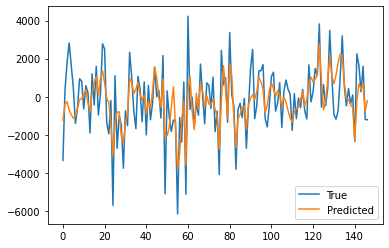

In [72]:
plt.plot(error_test, label='True')
plt.plot(error_test_pred, label='Predicted')
plt.legend()

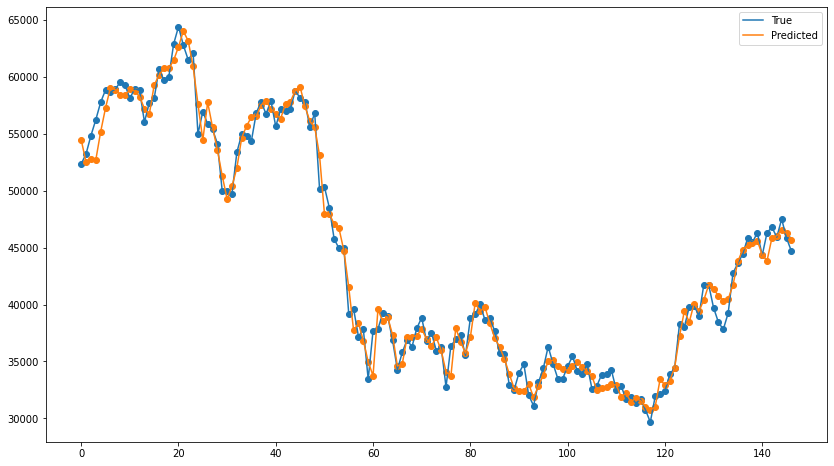

In [73]:
test_close_prices_final_pred = test_close_prices_pred + error_test_pred

plt.figure(figsize=(14, 8))
plt.plot(test_close_prices, label='True')
plt.plot(test_close_prices_final_pred, label='Predicted')
plt.scatter(np.arange(test_close_prices.shape[0]), test_close_prices)
plt.scatter(np.arange(test_close_prices.shape[0]), test_close_prices_final_pred)
plt.legend()

In [74]:
print(f'Test set MAE: {mean_absolute_error(test_close_prices, test_close_prices_final_pred)}')
print(f'Test set MAPE: {mean_absolute_percentage_error(test_close_prices, test_close_prices_final_pred)}')

Test set MAE: 993.3374464438803
Test set MAPE: 0.023095931249207526
